In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import random
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import PartialDependenceDisplay

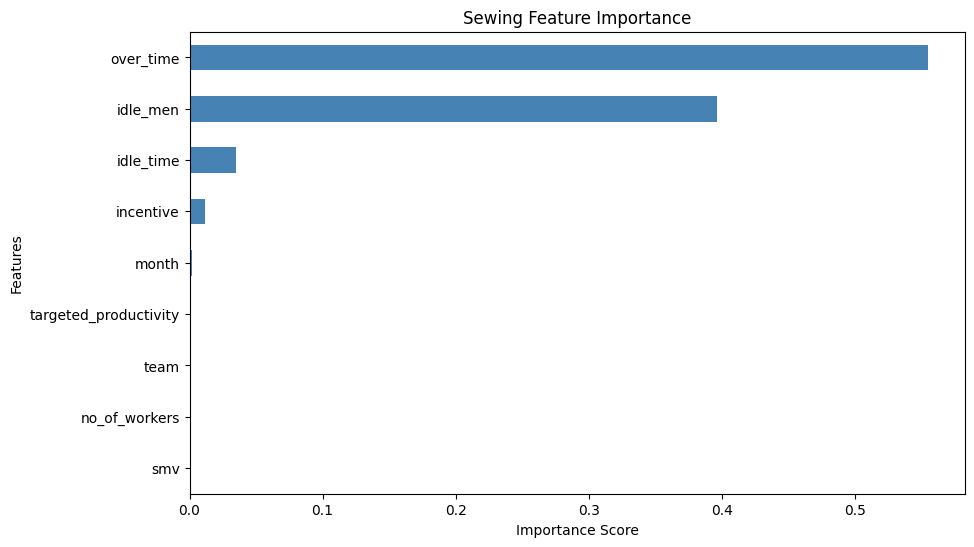

<Figure size 1000x600 with 0 Axes>

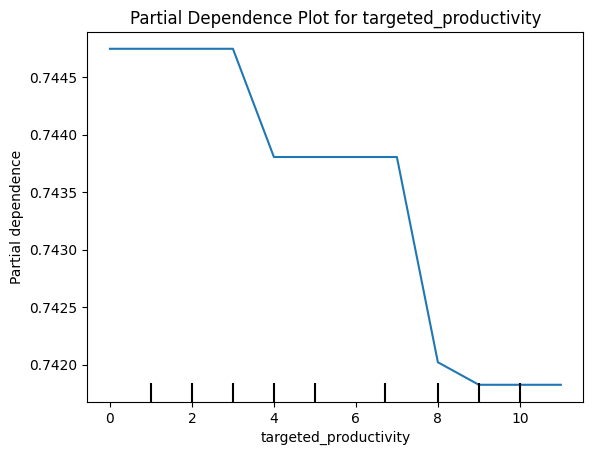

/Users/pasindumadusanka/myenv/lib/python3.13/site-packages/sklearn/inspection/_plot/partial_dependence.py:976: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


<Figure size 1000x600 with 0 Axes>

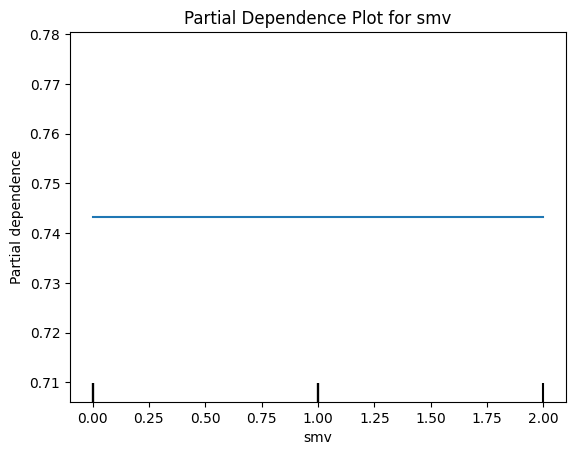

<Figure size 1000x600 with 0 Axes>

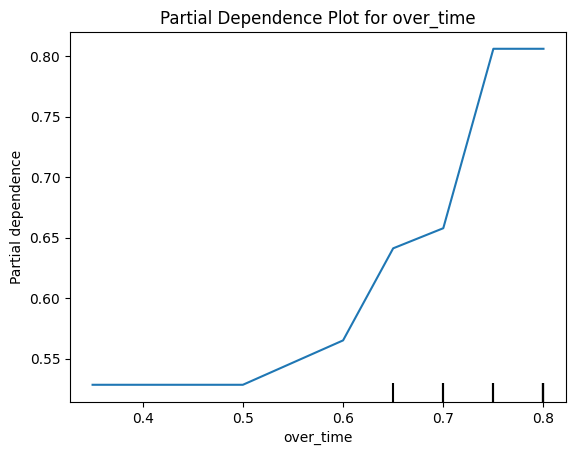

<Figure size 1000x600 with 0 Axes>

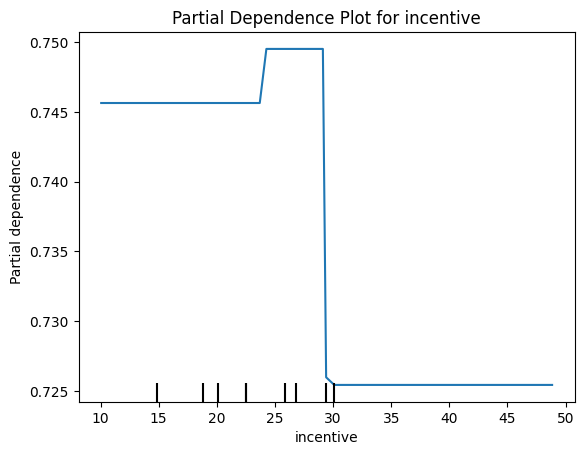

<Figure size 1000x600 with 0 Axes>

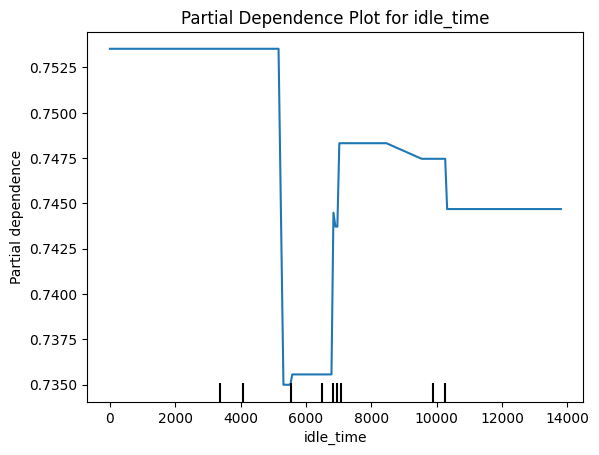

<Figure size 1000x600 with 0 Axes>

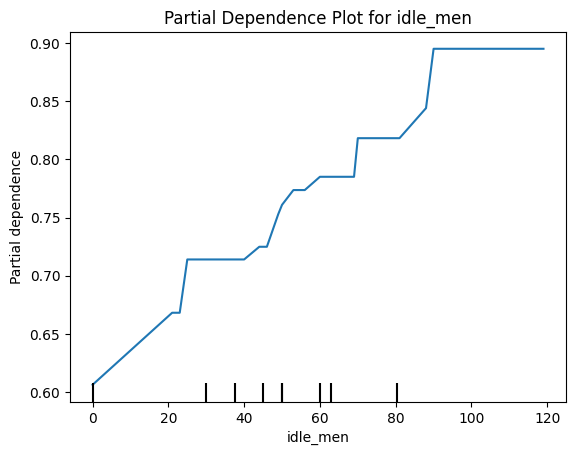

<Figure size 1000x600 with 0 Axes>

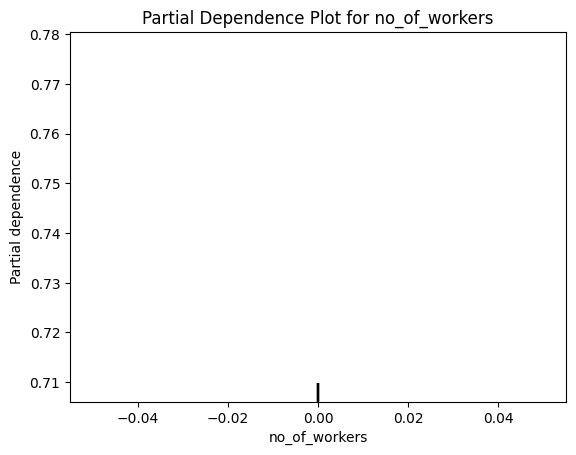

<Figure size 1000x600 with 0 Axes>

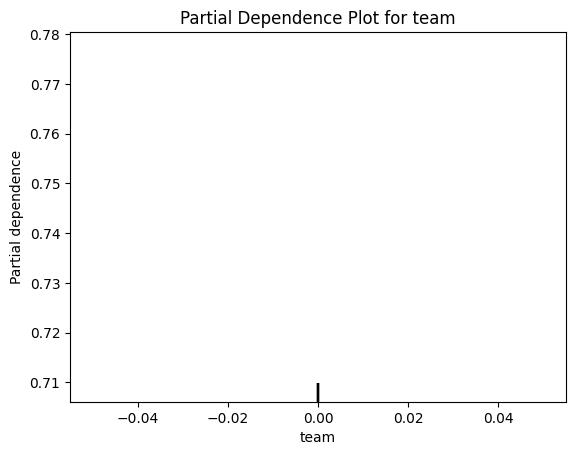

<Figure size 1000x600 with 0 Axes>

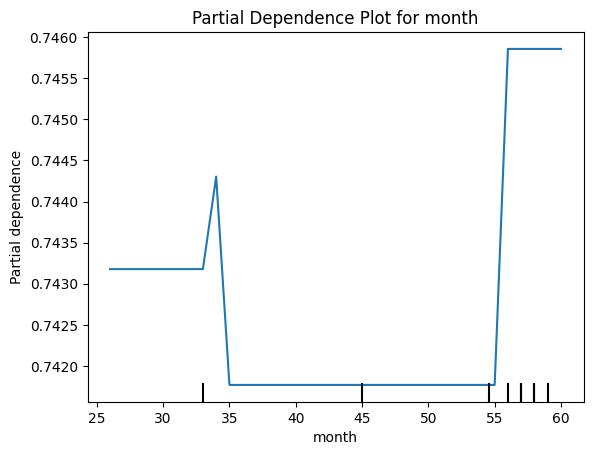

In [4]:
# Load data
train_set = pd.read_csv("train_cleandata.csv")
test_set = pd.read_csv("test_cleandata.csv")

# Convert categorical variables to categorical dtype
categorical_cols = ["quarter", "day", "team", "department", "month"]
train_set[categorical_cols] = train_set[categorical_cols].astype("category")
test_set[categorical_cols] = test_set[categorical_cols].astype("category")

# Define predictors
department_predictors = [
    "targeted_productivity", "smv", "over_time", "incentive",
    "idle_time", "idle_men", "no_of_workers", "team", "month"
]

department_predictors_finishing = [
    "targeted_productivity", "smv", "over_time", "no_of_workers", "team", "month"
]

overall_predictors = department_predictors + ["department"]

# Modified configuration
DEPARTMENTS = {
    "Sewing": department_predictors,
    "Finishing": department_predictors_finishing,
    "Overall": overall_predictors
}

OUTLIER_METHODS = {
    "isolation_forest": IsolationForest(contamination=0.1, random_state=42),
    "none": None
}

TREE_PARAMS = {
    'max_depth': [5, 8, 10, None],
    'min_samples_split': [8, 10, 15],
    'min_samples_leaf': [6, 8, 10],
    'max_features': [0.5, 0.6, 'sqrt'],
    'ccp_alpha': [0.0, 0.01, 0.1],
    'splitter': ['best', 'random']
}

def detect_outliers(data, method):
    """Detect outliers using specified method"""
    if method == "none":
        return data
    
    detector = OUTLIER_METHODS[method]
    numeric_cols = data.select_dtypes(include=np.number).columns
    detector.fit(data[numeric_cols])
    inliers = detector.predict(data[numeric_cols]) == 1
    return data[inliers]

def prepare_data(train, test, predictors, outlier_method):
    """Preprocess data with specified outlier handling"""
    # Detect and remove outliers
    train_clean = detect_outliers(train, outlier_method)
    test_clean = detect_outliers(test, outlier_method)
    
    # Separate features and target
    X_train = train_clean[predictors]
    X_test = test_clean[predictors]
    y_train = train_clean["actual_productivity"]
    y_test = test_clean["actual_productivity"]
    
    return X_train, X_test, y_train, y_test

def train_tree_model(X_train, y_train):
    """Parameter tuning with label encoded data"""
    tree = DecisionTreeRegressor(random_state=42)
    
    search = RandomizedSearchCV(
        tree, 
        TREE_PARAMS,
        n_iter=100,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        error_score='raise'
    )
    
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_

def run_analysis(department, outlier_method):
    """Updated pipeline with label encoding"""
    # Get appropriate data
    if department == "Overall":
        train = train_set
        test = test_set
    else:
        train = train_set[train_set["department"] == department.lower()]
        test = test_set[test_set["department"] == department.lower()]
    
    # Prepare data 
    X_train, X_test, y_train, y_test = prepare_data(
        train, test, DEPARTMENTS[department], outlier_method
    )
    
    # Modified preprocessing with label encoding
    categorical_cols = X_train.select_dtypes(include=['category']).columns
    preprocessor = ColumnTransformer([
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        categorical_cols)
    ], remainder='passthrough')
    
    # Transform data
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Train model
    best_model, best_params = train_tree_model(X_train_processed, y_train)
    
    # Evaluate
    metrics = {
        "train_mse": mean_squared_error(y_train, best_model.predict(X_train_processed)),
        "test_mse": mean_squared_error(y_test, best_model.predict(X_test_processed)),
        "train_r2": r2_score(y_train, best_model.predict(X_train_processed)),
        "test_r2": r2_score(y_test, best_model.predict(X_test_processed)),
        "best_params": best_params
    }
    
    # Get original feature names
    feature_names = list(X_train.columns)
    
    # Create feature importance plot
    importance = pd.Series(best_model.feature_importances_, index=feature_names)
    importance = importance.sort_values(ascending=True)
    
    plt.figure(figsize=(10, 6))
    importance.plot(kind='barh', color='steelblue')
    plt.title(f'{department} Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()
    
    # Create partial dependence plots
    for i, feature in enumerate(feature_names):
        plt.figure(figsize=(10, 6))
        PartialDependenceDisplay.from_estimator(best_model, X_train_processed, [i], feature_names=feature_names)
        plt.title(f'Partial Dependence Plot for {feature}')
        plt.show()
    
    return {
        "department": department,
        "outlier_method": outlier_method,
        **metrics
    }

# Run analysis with partial dependence plots
random.seed(42)
sewing_no_outlier_result = run_analysis("Sewing", "isolation_forest")

In [5]:
sewing_no_outlier_result

{'department': 'Sewing',
 'outlier_method': 'isolation_forest',
 'train_mse': 0.0028545651251133284,
 'test_mse': 0.0043241694101912595,
 'train_r2': 0.8328033586792118,
 'test_r2': 0.7184163311745292,
 'best_params': {'splitter': 'best',
  'min_samples_split': 8,
  'min_samples_leaf': 10,
  'max_features': 0.5,
  'max_depth': 8,
  'ccp_alpha': 0.0}}